# <center>Итоговый проект: Обработка естественного языка (NLP) в медицине</center>

## <center>Задание 1. Загрузить датасет и провести первичный анализ данных</center>

**1) <u>Загрузка датасета.</u>**

Датасет был предварительно загружен в формате *csv*.

**2) <u>Устанавливаем и импортируем необходимые библиотеки:</u>**

In [3]:
# Уберем предупреждения, чтобы они не загромождали вывод
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Устанавливаем библиотеку transformers для обучения предварительно обученных моделей в обработке естественного языка
# Устанавливаем библиотеку bitsandbytes, которая используется в приложениях искусственного интеллекта и машинного обучения
# Устанавливаем библиотеку Pandas
!pip install transformers bitsandbytes pandas
# # Устанавливаем PyTorch, библиотеку для работы с нейронными сетями
# !pip install torch --index-url https://download.pytorch.org/whl/cu118

In [6]:
import pandas as pd             # Для работы с табличными данными
import matplotlib.pyplot as plt # Импорт функции pyplot из библиотеки matplotlib для создания графиков и визуализаций
import seaborn as sns           # Для создания визуализаций данных
import numpy as np              # Для работы с массивами и числовыми операциями
import torch                    # Для работы с нейронными сетями
import nltk                     # Набор инструментов для символьной и статистической обработки естественного языка
import tqdm as tqdm             # Модуль tqdm предназначен для быстрого и расширяемого внедрения индикаторов выполнения
import random                   # Модуль random предоставляет функции для генерации псевдослучайных чисел, букв и случайного выбора элементов последовательности

In [7]:
from sklearn.feature_extraction.text import CountVectorizer # Преобразует коллекцию текстовых документов в числовую матрицу подсчётов слов или токенов
from sklearn.decomposition import LatentDirichletAllocation # LDA — это вероятностная модель, разработанная для моделирования тем в коллекциях документов
from nltk.corpus import stopwords                           # Для удаления стоп-слов из текста
from textblob import TextBlob                               # TextBlob — это библиотека для обработки текстовых данных

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification # BertTokenizer служит для токенизации и кодирования текстовых данных, а BertForSequenceClassification позволяет загружать предобученную модель BERT для задачи классификации
from transformers import pipeline                                     # Упрощает использование предварительно обученных моделей в библиотеке Transformers
from torch.utils.data import DataLoader                               # Встроенный класс, который обеспечивает эффективный и гибкий способ загрузки данных в модель для обучения или вывода
from collections import defaultdict                                   # Используется, когда нужно предоставить значение по умолчанию для ключей, которые ещё не существуют в словаре

In [9]:
# Проверим, обнаруживает ли PyTorch GPU и может ли использовать его для обучения моделей
torch.cuda.is_available()

False

In [10]:
# Функции, помогающие контролировать рандомность
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

**3) <u>Представляем датасет в формате *pandas df*:</u>**

P.S. 
Датасет был взят по [ссылке](https://github.com/yandex/geo-reviews-dataset-2023/blob/master/geo-reviews-dataset-2023.tskv), отправить его в Git не получилось из-за размера.

In [ ]:
# Открываем данные
project_df = pd.read_csv('data/geo-reviews-dataset-2023.csv')
project_df

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.0,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.0,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.0,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.0,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.0,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...
...,...,...,...,...,...
499995,"Москва, Южный административный округ, район Би...",Бирюлёво-Пассажирская,4.0,Железнодорожная станция,"Охрана кривая но добрая, двери не закрываются ..."
499996,"Москва, Южный административный округ, район Би...",Бирюлёво-Пассажирская,4.0,Железнодорожная станция,По сравнению со многими современными платформа...
499997,"Новосибирск, Коммунистическая улица, 48А",NaN,5.0,"Бар, паб","Приятная атмосфера, прекрасное вино, волшебная..."
499998,"Астраханская область, Харабалинский район",Сарай-Бату,5.0,Достопримечательность,Был с семьёй 13.06.23 Отличное место. Рекоменд...


**4) <u>Фильтруем данные по больницам Москвы, используя столбцы `'address'` и `'rubrics'`:</u>**

In [12]:
# Создаём новую фильтрованную переменную с московскими больницами
msc_hospitals = project_df[(project_df['address'].str.contains('Москва', na=False)) & (project_df['rubrics'].str.contains('больница', na=False, case=False))]
msc_hospitals

,address,name_ru,rating,rubrics,text
1055,"Москва, 11-я Парковая улица, 32, корп. 4","ГКБ им. Д. Д. Плетнёва, пульмонологическое отд...",5.0,Больница для взрослых,Опытные специалисты! Уважительное отношение к ...
1255,"Москва, Погодинская улица, 1с1",Клиника колопроктологии и малоинвазивной хирургии,5.0,"Больница для взрослых;Медцентр, клиника;Специа...",Самая лучшая клиника!\nСамые лучшие врачи и ме...
1256,"Москва, Погодинская улица, 1с1",Клиника колопроктологии и малоинвазивной хирургии,5.0,"Больница для взрослых;Медцентр, клиника;Специа...","Лучшие специалисты, лечат мою мамочку👍Админист..."
2109,"Москва, Троицк, Юбилейная улица, 5","Троицкая центральная городская больница, стома...",5.0,Стоматологическая поликлиника;Больница для взр...,За весь персонал ничего не могу сказать. А вот...
4636,"Москва, улица Матросская Тишина, 14","Детская поликлиника № 52, филиал № 1",5.0,Детская поликлиника;Детская больница,"Все чистое, новое, вежливый персонал.\n\n"
...,...,...,...,...,...
487965,"Москва, 4-я Тверская-Ямская улица, 16",ФГАУ НМИЦ нейрохирургии им. академика Н.Н. Бур...,5.0,Больница для взрослых,От всей души благодарим профессора Шиманского ...
494531,"Москва, поселение Вороновское, посёлок ЛМС, ми...",ГБУЗ Вороновская больница,5.0,Больница для взрослых;Поликлиника для взрослых...,"Отлично организованный ,доброжелательный, высо..."
494532,"Москва, поселение Вороновское, посёлок ЛМС, ми...",ГБУЗ Вороновская больница,5.0,Больница для взрослых;Поликлиника для взрослых...,Большое спасибо всему персоналу неврологическо...
499460,"Москва, 2-й Боткинский проезд, 5, корп. 19","Больница им. С.П. Боткина, корпус № 19",5.0,Больница для взрослых,"Пожалуй, лучшая больница, в которой мне довело..."


**5) <u>Строим график распределения рейтингов больниц в Москве:</u>**

In [13]:
# Проверяем на дубликаты
msc_hospitals.duplicated().sum()

0

In [14]:
# Проверим кол-во пропущенных значений в каждом признаке
msc_hospitals.isna().sum()

,0
address,0
name_ru,0
rating,0
rubrics,0
text,0


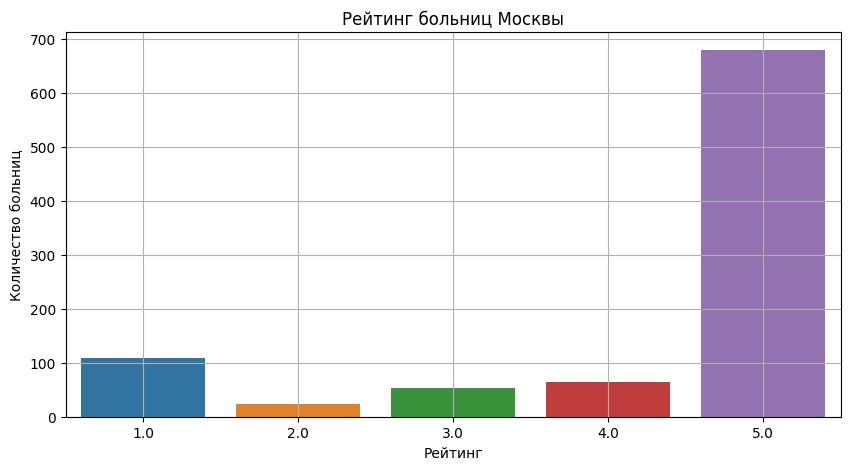

In [15]:
# Строим график распределения рейтингов
plt.figure(figsize=(10, 5))
sns.countplot(data=msc_hospitals, x='rating', palette='tab10')
plt.title('Рейтинг больниц Москвы')
plt.xlabel('Рейтинг')
plt.ylabel('Количество больниц')
plt.grid(True)
plt.show()

**6) <u>Строим график топ-10 больниц по количеству отзывов:</u>**

Для этого применим функцию `groupby()` по признаку `'name_ru'`. Дополнительно используем функцию `agg()`, чтобы агрегировать другие признаки внутри группировки по нужным нам параметрам:
* `'address'` не надо агрегировать, т.к. для одной и той же больницы адреса должны совпадать;

* `'rating'` агрегируем по среднему значению;
* `'rubrics'` это описание профиля больницы, так же как и адрес, должно совпадать для одной и той же больницы;
* `'text'` отзывы, количество которых нам нужно подсчитать.

In [16]:
# Новая сгрупированная переменная
msc_hospitals_reviews = msc_hospitals.groupby('name_ru').agg({'rating': 'mean', 'text': 'count'})
msc_hospitals_reviews

,rating,text
name_ru,,
12-е Инфекционное отделение,1.000000,1
18 Гинекологическое отделение,3.000000,2
36 Урологическое отделение,5.000000,1
7-е отделение Реанимации и Интенсивной Терапии,5.000000,2
"9 имени Г. Н. Сперанского, 4 хирургическое отделение нейрохирургии",5.000000,1
...,...,...
Центральная клиническая больница Управления делами Президента Российской Федерации,4.500000,2
Центральная клиническая больница с поликлиникой Управления делами Президента РФ,4.142857,7
Цэлт,5.000000,5


Уже на этом этапе видно, что в датасете отзывы не только о больницах, но и о конкретных отделениях. Можно было бы выяснить к каким больницам относятся те или иные отделения, сгруппировать их дополнительно, но в задании ничего по этому поводу не сказано.

In [17]:
# Топ-10 больниц по кол-ву отзывов
top_10 = msc_hospitals_reviews.nlargest(10, 'text')
top_10

,rating,text
name_ru,,
ГБУЗ Морозовская детская городская клиническая больница ДЗМ,4.228571,35
Городская клиническая больница имени С. С. Юдина,3.875000,24
Городская больница имени С.П. Боткина,4.130435,23
ГБУЗ Детская городская клиническая больница имени З.А. Башляевой,4.666667,21
Городская клиническая больница № 15 имени О. М. Филатова,4.857143,21
Московский многопрофильный клинический центр Коммунарка,4.761905,21
Городская клиническая больница № 67 имени Л. А. Ворохобова,4.100000,20
Городская клиническая больница имени В.М. Буянова,4.105263,19
Городская клиническая больница имени А.К. Ерамишанцева,4.076923,13


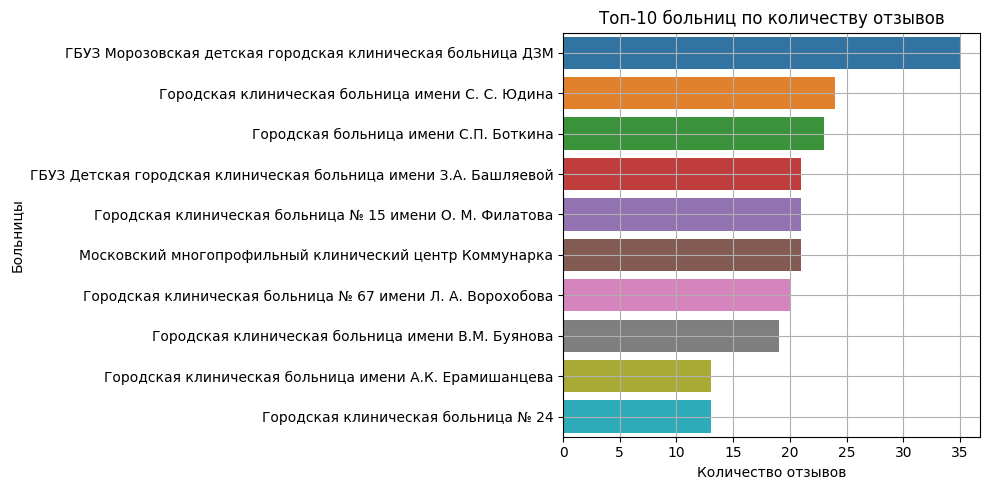

In [18]:
# Строим график
plt.figure(figsize=(10, 5))
sns.barplot(data=top_10, y='name_ru', x='text', palette='tab10')
plt.title('Топ-10 больниц по количеству отзывов')
plt.xlabel('Количество отзывов')
plt.ylabel('Больницы')
plt.tight_layout()
plt.grid(True)
plt.show()

## <center>Задание 2. Сентимент-анализ с использованием модели на основе *BERT*</center>

**1) <u>Загрузить предобученный токенизатор и модель для сентимент-анализа:</u>**

In [19]:
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

**2) <u>Перемещение вычислений на *GPU*:</u>**

`torch.device()` — это объект, представляющий устройство, на котором выделяется тензор в библиотеке *PyTorch*. Он содержит тип устройства (обычно «cpu» или «cuda», но также потенциально «mps», «xpu», «xla» или «meta») и дополнительный индекс устройства для типа устройства.

`torch.cuda.is_available()` — функция в библиотеке *PyTorch*, которая определяет, доступна ли поддержка *cuda* в системе.

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

**3) <u>Сентимент-анализ:</u>**

In [22]:
def sentiment_analysis(text):
    """Функция для проведения сентимент-анализа для отзыва"""
    # Токенизация текста
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)

    # Получение предсказаний
    with torch.no_grad():
        outputs = model(**inputs)

    # Извлечение метки с максимальной вероятностью
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()
    return predicted_label

In [23]:
# Применение функции ко всем отзывам и сохранение нового признакак в столбец 'sentiments'
msc_hospitals['sentiment'] = msc_hospitals['text'].apply(sentiment_analysis)

In [24]:
# Соотношение в группах
msc_hospitals['sentiment'].value_counts()

,count
sentiment,
4,598
0,150
3,93
1,72
2,17


Для каждого отзыва мы получили метку от 0 до 4:
* 0 — очень негативный отзыв,
* 1 — негативный отзыв,
* 2 — нейтральный отзвы,
* 3 — позитивный отзыв,
* 4 — очень позитивный отзыв.

In [25]:
from sklearn import metrics # Метод metrics из библиотеки Scikit-Learn, который рассчитывает основные метрики для оценки производительности алгоритма

In [26]:
# Построим confusion_matrix для оценки сентимент-анализа
y_true = msc_hospitals['rating']
y_pred = msc_hospitals['sentiment'] + 1
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'True')]

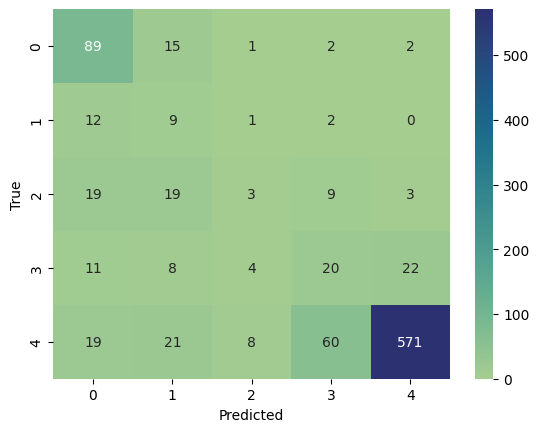

In [27]:
ax = sns.heatmap(confusion_matrix, annot=True, fmt='', cmap="crest")
ax.set(xlabel="Predicted", ylabel="True")

В задании ничего не сказано, касательно результатов анализа сентимент-анализа, поэтому продолжим работать с получившимися предсказаниями.

**4) <u>График распределения оценок по сентимент-анализу:</u>**

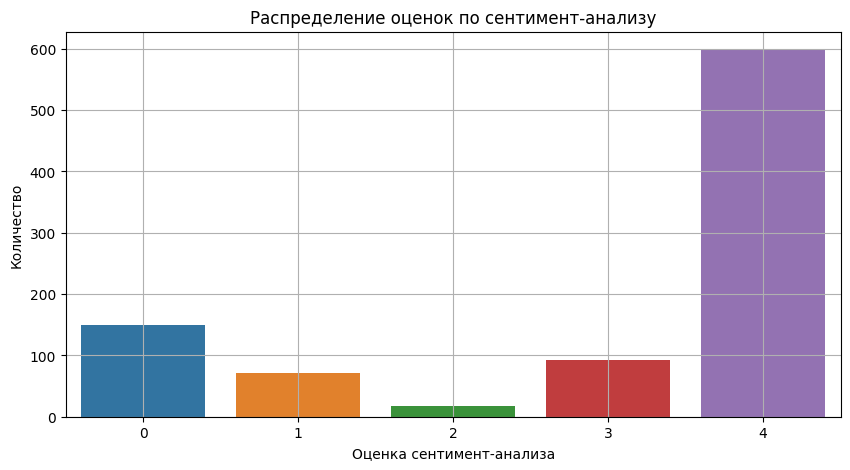

In [28]:
plt.figure(figsize=(10, 5))
sns.countplot(data=msc_hospitals, x='sentiment', palette='tab10')
plt.title('Распределение оценок по сентимент-анализу')
plt.xlabel('Оценка сентимент-анализа')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

## <center>Задание 3. Анализ негативных комментариев с оценкой после сентимент-анализа от 0 до 2 с помощью *LDA*</center>

**1) <u>Фильтрация значений в столбце `'sentiment'` от 0 до 2:</u>**

In [29]:
# Отбираем отзывы от 0 до 2
reviews_0_2 = msc_hospitals[(msc_hospitals['sentiment'] == 0)|(msc_hospitals['sentiment'] == 1)|(msc_hospitals['sentiment'] == 2)]
reviews_0_2['sentiment'].value_counts()

,count
sentiment,
0,150
1,72
2,17


**2) <u>Подсчёт, сколько раз каждая больница встречается в негативных отзывах:</u>**

In [30]:
# Создаём новую переменную, в которой посчитаны все отзывы от 0 до 2 на каждую больницу
hospitals_with_neg_reviews = reviews_0_2['name_ru'].value_counts()

# Отбираем топ-10 в этом списке
top_10_with_neg_reviews = hospitals_with_neg_reviews.head(10)
top_10_with_neg_reviews

,count
name_ru,
Городская клиническая больница № 67 имени Л. А. Ворохобова,8
ГБУЗ Морозовская детская городская клиническая больница ДЗМ,8
Городская клиническая больница имени С. С. Юдина,8
Городская больница имени С.П. Боткина,6
Городская клиническая больница № 31,5
Городская клиническая больница имени В.М. Буянова,5
ГБУЗ ГКБ им. В. П. Демихова ДЗМ,5
"Ммкц Коммунарка, центр амбулаторной онкологической помощи",4
Городская клиническая больница № 29 имени Н.Э. Баумана,4


**3) <u>Анализ негативных комментариев больницы, которая заняла первое место:</u>**

У нас таких больниц три. На всякий случай проверим соответствуют ли отзывы о них негативному контексту.

In [31]:
worst_1_hospital, worst_2_hospital, worst_3_hospital = sorted([top_10_with_neg_reviews.index[0], top_10_with_neg_reviews.index[1], top_10_with_neg_reviews.index[2]])

In [32]:
# Получаем все ранее сохранённые негативные отзывы на эту больницу
worst_1_hospital_reviews = reviews_0_2[reviews_0_2['name_ru'] == worst_1_hospital]
worst_1_hospital_reviews

,address,name_ru,rating,rubrics,text,sentiment
27268,"Москва, 4-й Добрынинский переулок, 1/9с21",ГБУЗ Морозовская детская городская клиническая...,1.0,Детская больница,"Больницу не посещала, попросту не могу попасть...",0
27269,"Москва, 4-й Добрынинский переулок, 1/9с21",ГБУЗ Морозовская детская городская клиническая...,1.0,Детская больница,"Во что превратилась Морозовская больница, это ...",0
27271,"Москва, 4-й Добрынинский переулок, 1/9с21",ГБУЗ Морозовская детская городская клиническая...,5.0,Детская больница,Тысячи проходов на здание но пропускает только...,1
27279,"Москва, 4-й Добрынинский переулок, 1/9с21",ГБУЗ Морозовская детская городская клиническая...,1.0,Детская больница,Скорая отправила с ребёнком в больницу. В виду...,0
27285,"Москва, 4-й Добрынинский переулок, 1/9с21",ГБУЗ Морозовская детская городская клиническая...,1.0,Детская больница,"не скажу за всю больницу целиком, но 8 гематол...",1
27287,"Москва, 4-й Добрынинский переулок, 1/9с21",ГБУЗ Морозовская детская городская клиническая...,3.0,Детская больница,"Больница хорошая, палаты чистые, но вместо обс...",2
27293,"Москва, 4-й Добрынинский переулок, 1/9с21",ГБУЗ Морозовская детская городская клиническая...,2.0,Детская больница,Почему не возможно со всех сторон открыть вход...,0
27297,"Москва, 4-й Добрынинский переулок, 1/9с21",ГБУЗ Морозовская детская городская клиническая...,3.0,Детская больница,"Отличный приемный покой, оперативные анализы и...",1


In [33]:
# Сделаем всё то же самое для второй больницы с таким же кол-вом отзывывов
worst_2_hospital_reviews = reviews_0_2[reviews_0_2['name_ru'] == worst_2_hospital]
worst_2_hospital_reviews

,address,name_ru,rating,rubrics,text,sentiment
103063,"Москва, Коломенский проезд, 4",Городская клиническая больница имени С. С. Юдина,3.0,Больница для взрослых,Специалисты работают шикарные. \nНо в плане ор...,0
103069,"Москва, Коломенский проезд, 4",Городская клиническая больница имени С. С. Юдина,1.0,Больница для взрослых,"К самой больнице претензий нет, лечат, обращаю...",1
103072,"Москва, Коломенский проезд, 4",Городская клиническая больница имени С. С. Юдина,1.0,Больница для взрослых,"Мама, лежала месяц у них в реаниации, за этот ...",0
103074,"Москва, Коломенский проезд, 4",Городская клиническая больница имени С. С. Юдина,1.0,Больница для взрослых,Врагу не пожелаешь попасть в приемный покой в ...,0
103075,"Москва, Коломенский проезд, 4",Городская клиническая больница имени С. С. Юдина,2.0,Больница для взрослых,Больница после ремонта. \nНе понятная ситуация...,2
103081,"Москва, Коломенский проезд, 4",Городская клиническая больница имени С. С. Юдина,3.0,Больница для взрослых,Оперировалась в 4 травме у Мазалова АВ очень г...,1
103082,"Москва, Коломенский проезд, 4",Городская клиническая больница имени С. С. Юдина,5.0,Больница для взрослых,Хочу выразить благодарность персоналу 4 ХО.Все...,0
103084,"Москва, Коломенский проезд, 4",Городская клиническая больница имени С. С. Юдина,5.0,Больница для взрослых,Дважды пришлось прокатиться здесь на лифте. Пе...,1


In [34]:
# Сделаем всё то же самое для последней больницы с таким же кол-вом отзывывов
worst_3_hospital_reviews = reviews_0_2[reviews_0_2['name_ru'] == worst_3_hospital]
worst_3_hospital_reviews

,address,name_ru,rating,rubrics,text,sentiment
174697,"Москва, улица Саляма Адиля, 2/44с1",Городская клиническая больница № 67 имени Л. А...,3.0,Больница для взрослых,"Связи нет, но есть открытая сеть WI FI. Поступ...",0
174698,"Москва, улица Саляма Адиля, 2/44с1",Городская клиническая больница № 67 имени Л. А...,4.0,Больница для взрослых,Парковки нет!!! Вечно все занято таксистами. \...,0
174700,"Москва, улица Саляма Адиля, 2/44с1",Городская клиническая больница № 67 имени Л. А...,3.0,Больница для взрослых,Пока сказать что-то конкретное трудно. Идёт ре...,1
174702,"Москва, улица Саляма Адиля, 2/44с1",Городская клиническая больница № 67 имени Л. А...,1.0,Больница для взрослых,"после госпитализации, больных не выпускают яко...",0
174703,"Москва, улица Саляма Адиля, 2/44с1",Городская клиническая больница № 67 имени Л. А...,3.0,Больница для взрослых,Обследовался по направлению от военкомата. Отд...,2
174706,"Москва, улица Саляма Адиля, 2/44с1",Городская клиническая больница № 67 имени Л. А...,1.0,Больница для взрослых,Дважды ездила по скорой в 67 больницу по скоро...,0
174707,"Москва, улица Саляма Адиля, 2/44с1",Городская клиническая больница № 67 имени Л. А...,5.0,Больница для взрослых,Положили 04.07.23. В 67 гкб. из области Дмитро...,0
174710,"Москва, улица Саляма Адиля, 2/44с1",Городская клиническая больница № 67 имени Л. А...,3.0,Больница для взрослых,Заразили маму ковидом в отделении кардиологии ...,0


Во всех трёх случаях в результате сентимент-анализа один-два положительных отзыва были оценены как негативные.

In [35]:
# Посчитаем, у кого меньше средний рейтинг по отрицательным отзывам, та больница и будет "the worst"
print(f"Для {worst_1_hospital} средний рейтинг отрицательных отзывов = {worst_1_hospital_reviews['rating'].mean()}")
print(f"Для {worst_2_hospital} средний рейтинг отрицательных отзывов = {worst_2_hospital_reviews['rating'].mean()}")
print(f"Для {worst_3_hospital} средний рейтинг отрицательных отзывов = {worst_3_hospital_reviews['rating'].mean()}")

Для ГБУЗ Морозовская детская городская клиническая больница ДЗМ средний рейтинг отрицательных отзывов = 2.125
Для Городская клиническая больница имени С. С. Юдина средний рейтинг отрицательных отзывов = 2.625
Для Городская клиническая больница № 67 имени Л. А. Ворохобова средний рейтинг отрицательных отзывов = 2.875


Вывод: первое место среди больниц с наибольшим кол-вом отрицательных отзывов заняла "ГБУЗ Морозовская детская городская клиническая больница ДЗМ".

In [36]:
the_worst_hospital_reviews = worst_1_hospital_reviews

**4) <u>Классификация этих отзывов:</u>**

In [37]:
# Категории
labels = ["Запись в больницу",
          "Квалификация врачей",
          "Качество лечения",
          "Ремонт и оборудование"
]

In [38]:
# Модель и классификатор
model_name = "bert-base-cased"
classifier = pipeline("zero-shot-classification", model=model_name, device=0)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Device set to use cpu
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


In [39]:
# Разбиение отзывов на предложения
sentences = []
for review in the_worst_hospital_reviews['text']:
    sentences.extend([s.strip() for s in review.split('\n') if s.strip()])

**5) <u>Построение словаря:</u>**

Из задания: "На основе максимального значения отнесите каждый к своей категории и постройте словарь, где ключ — это название метки, а значения — предложения, относящиеся к данной проблеме."

In [40]:
# Классификация предложений
results = {}
for label in labels:
    results[label] = []

for sentence in sentences:
    prediction = classifier(sentence, labels)
    max_score_index = np.argmax(prediction['scores'])
    assigned_label = prediction['labels'][max_score_index]
    results[assigned_label].append(sentence)

In [41]:
# Вывод результатов классификации
for label, sentences in results.items():
    print(f"\n{label}:")
    for sentence in sentences:
        print(f"- {sentence}")


Запись в больницу:
- Больницу не посещала, попросту не могу попасть, дозвониться практически не реально! Целую неделю звонила чтоб записаться на прием на платной основе. Дозвонилась запись сформирована звоните 23го, звоню 23го никто не отвечает. По отзывам такая прекрасная больница что же вы не наладите работу телефонии, запись нужна срочно ждать когда обработают мою заявку из кол-центра не могу.
- Тысячи проходов на здание но пропускает только из одного. Навигатор ведёт одного из них но ты должен искать главный проход и это займёт не мало времени ведь здание слишком большой. И очередь для получения пропуска.
- Скорая отправила с ребёнком в больницу. В виду того что в районе нижней челюсти распухла щека. \n17.03.23\nПошли к дежурному стоматологу, стоматолог сделал рентген, поставил диагноз отправил в челюстно-лицевую хирургию делать надрез деснв. В ЧЛХ сказали что стоматолог не правильно поставил диагноз, операция не нужна, нооо если сильнее раздует мы должны будем вернуться. Окей, ве

Не могу сказать, что согласен с тем, как распределены отзывы по категориям, но будем работать с тем, что получили. Возможно, такой результат получен, потому что машина обучалась только на английском языке.

**6) <u>Построение графика:</u>**

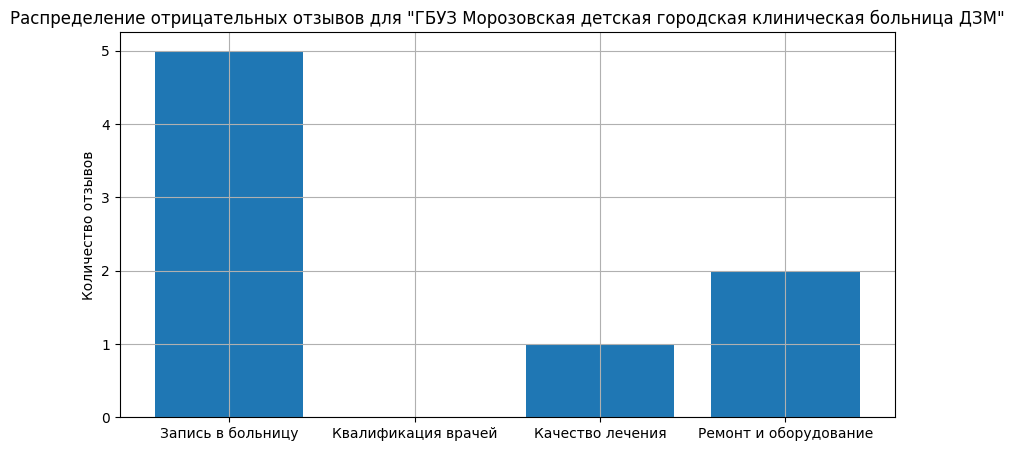

In [42]:
# График, отражающий количество отзывов в каждой категории
counts = [len(results[label]) for label in labels]
plt.figure(figsize=(10, 5))
plt.bar(labels, counts)
plt.title(f'Распределение отрицательных отзывов для "{worst_1_hospital}"')
plt.ylabel('Количество отзывов')
plt.grid(True)
plt.show()

## <center>Задание 4. Генерация рекомендаций по улучшению работы больницы на основе полученных ранее негативных отзывов</center>

**1) <u>Загрузка модели:</u>**

In [43]:
from transformers import AutoTokenizer # Класс в библиотеке Hugging Face Transformers, который автоматически выбирает и загружает подходящий токенизатор для заданной предварительно обученной модели

In [44]:
# Модель и токенизатор
model_name = "facebook/xglm-7.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/449 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.92M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.03M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

**2) <u>Квантование:</u>**

In [45]:
# AutoModelForCausalLM позволяет использовать предварительно обученные модели для генерации текста на основе заданной входной последовательности
# BitsAndBytes — самый простой вариант для квантования модели до 8 и 4 бит
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

In [46]:
# Настройка квантования с помощью BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,      # 8-битное квантование
    llm_int8_threshold=6.0, # Порог для активации квантования
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="cuda",              # Автоматическое распределение по устройствам
    quantization_config=bnb_config, # Новый способ задания квантования
    torch_dtype=torch.float16       # Для оптимизации вычислений
)

**3) <u>Генерация рекомендаций по решению проблем, используя полученные негативные отзывы для одной больницы:</u>**

In [ ]:
text_with_sentiments = the_worst_hospital_reviews[['text', 'sentiment']]

In [ ]:
# Объединение сообщений из всех категорий в одну
all_texts = []
for i, row in text_with_sentiments.iterrows():
    all_texts.append(row['text'])

# Объединяем весь текст в одну строку
full_text = "\n".join(all_texts)

In [ ]:
# Проверка результата
print(full_text)

Больницу не посещала, попросту не могу попасть, дозвониться практически не реально! Целую неделю звонила чтоб записаться на прием на платной основе. Дозвонилась запись сформирована звоните 23го, звоню 23го никто не отвечает. По отзывам такая прекрасная больница что же вы не наладите работу телефонии, запись нужна срочно ждать когда обработают мою заявку из кол-центра не могу. 

Во что превратилась Морозовская больница, это ужасно. После 2 неудачных операций в нашем городе по направлению из электростальской детской поликлиники моей дочери, Дарье Дроздовой, 23.10.2008 г.р., сделали операцию в МДГКБ: удалили вросший ноготь на ноге, вырезали грануляционную ткань,  сформировали валики (как  выяснилось позже, неправильно), операция была в декабре 2022, хирург Копылов. По его рекомендации ходили к подологу. После трёх посещений подолог от нас отказалась, так как, с её слов, валики по бокам ногтя сходятся, а не расходятся, и помочь она не сможет, ногтю просто некуда расти, кроме как врезаться 

In [ ]:
prompt = f"""Помоги сформировать предложения по улучшениям для больницы {worst_1_hospital},
Изучи данный список отзывов и составь свои рекомендации:\n
{full_text}\n
Рекомендации по улучшению:\n"""

# Токенизация текста
inputs = tokenizer(prompt, return_tensors="pt")
inputs = inputs.to(model.device)

# Генерация текста рекомендаций
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_length=2048,
        temperature=1,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

# Декодирование текста
recommendations = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(recommendations)

Учитывая, что ничего не получилось на данной модели, попробуем на другой.

In [ ]:
# Модель и токенизатор
model_name = "Qwen/Qwen2.5-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="cuda",              # Автоматическое распределение по устройствам
    quantization_config=bnb_config, # Новый способ задания квантования
    torch_dtype=torch.float16       # Для оптимизации вычислений
)

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [ ]:
prompt = f"""Помоги сформировать предложения по улучшениям для больницы {worst_1_hospital},
Изучи данный список отзывов и составь свои рекомендации:\n
{full_text}\n
Рекомендации по улучшению:\n"""

# Токенизация текста
inputs = tokenizer(prompt, return_tensors="pt")
inputs = inputs.to(model.device)

# Генерация текста рекомендаций
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_length=2048,
        temperature=1,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

# Декодирование текста
recommendations = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(recommendations)


Сгенерированные рекомендации:
Помоги сформировать предложения по улучшениям для больницы Городская клиническая больница имени С. С. Юдина, 
Изучи данный список отзывов и составь свои рекомендации: 
<Reviews>Специалисты работают шикарные. \nНо в плане организации процессов - ужас. В процессе связка и 3-х человек и никто не понимает дальше своего собственного этапа, что делать, куда идти. \n\nВопрос решили мой отлично на 5+, но решали 20 минут, а гулял там почти весь день - выпытывая у всех подряд что происходит и что мне дальше делать

Ужасная больница, лежала в ней 20 лет назад, до сих пор ничего не изменилось, Попала сейчас туда подруга, провела в приемном покое с 8 утра и до 8 вечера, человек с болью в почках и температурой. Бардак так и остался. Пища ужасная.

К самой больнице претензий нет, лечат, обращаются хорошо.\n Но еда как и везде в больницах не айс. \nРешила пойти в местную столовую «кафе»… лучше есть больничную еду, чем то, что продают в их местном кафе!!! Больному человек